# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [2]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162733 sha256=a8744a5314b7a6da69bbf47b788103e95a17ba18f156c9ce05b10a664d5b796e
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [3]:
#basic python libraries
import pandas as pd
import numpy as np

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt

#turn off warnings
import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Deep Learning/ratings_Electronics.csv")

In [5]:
data.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


### Observations
The dataset is missing column headers

### Observations
The data has two object type variables and two numeric type variables.

In [6]:
# add column headers
cols = ['user_id', 'prod_id', 'rating', 'timestamp']
data.columns = cols
data.head()

,user_id,prod_id,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [7]:
#copy data to not alter original dataset
df = data.copy(deep=True)
df.head()

,user_id,prod_id,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [8]:
# drop timestamp column
df = df.drop('timestamp', axis = 1)
df.head(1)

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [9]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [10]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [11]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [12]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [13]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [14]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

**Write your observations here:**
There are 65290 rows

### **Data types**

In [15]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Write your observations here:**

**user_id** and **prod_id** are both type 'object'.

**rating** is type numeric

There are no missing values (non-null = # of entries for each column)

### **Checking for missing values**

In [16]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Write your observations here:**

There are no missing values in the dataset

### **Summary Statistics**

In [17]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe().T


,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Write your observations here:**

Again, there are a total of 65290 observations

The **mean** rating is 4.29

The **lowest** rating is 1

The **median** is higher than the mean suggesting a skew left.


### **Checking the rating distribution**

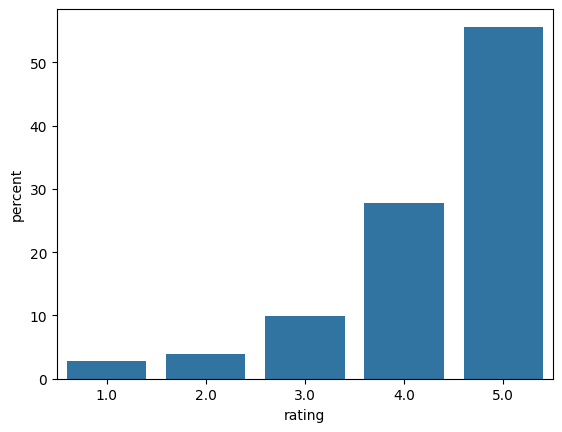

In [18]:
# Create the bar plot and provide observations
sns.countplot(df_final, x = 'rating', stat = 'percent')
plt.show()

**Write your observations here:**

More than half of the ratings are **5**.

Slightly less than 30% of the ratings are **4**.

The results are left-skewed/right shifted showing that most users tend to rate a product more often when it is something they want to recommend. Users are less likely to rate a product they do not like.


### **Checking the number of unique users and items in the dataset**

In [19]:
# Number of total rows in the data and number of unique user id and product id in the data

row, col = df_final.shape
user_uni = df_final['user_id'].nunique()
prod_uni = df_final['prod_id'].nunique()
print("Number of unique users: ", user_uni)
print("Number of unique products: ",prod_uni)
print("Number of total rows:", row)


Number of unique users:  1540
Number of unique products:  5689
Number of total rows: 65290


**Write your observations here:**

The total number of rows in the data is 65290.

Total number of unique users is 1540.

Total number unique products is 5489

### **Users with the most number of ratings**

In [20]:
# Top 10 users based on the number of ratings
df_final.user_id.value_counts(ascending = False).nlargest(10)

ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: user_id, dtype: int64

**Write your observations here:**

The top 10 users range from users with 179 reviews up to 295.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [21]:
# Calculate the average rating for each product
prod_avg = df_final.groupby(['prod_id']).mean()
prod_avg.rename(columns = {'rating':'avg_rating'}, inplace = True)
prod_avg.head()

,avg_rating
prod_id,
1400501466,3.333333
1400532655,3.833333
1400599997,4.000000
9983891212,4.875000
B00000DM9W,5.000000


In [22]:
# Calculate the count of ratings for each product
prod_count = df_final.groupby(['prod_id']).count()
prod_count.rename(columns = {'rating':'count_rating'}, inplace = True)
prod_count.head(5)

,user_id,count_rating
prod_id,,
1400501466,6,6
1400532655,6,6
1400599997,5,5
9983891212,8,8
B00000DM9W,5,5


In [23]:
# Create a dataframe with calculated average and count of ratings
final_rating = pd.merge(prod_avg, prod_count, how = 'left', on = 'prod_id')
final_rating.drop(['user_id'], axis = 1, inplace = True)
final_rating.head()

,avg_rating,count_rating
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [24]:
# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values('count_rating', ascending = False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,count_rating
prod_id,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


In [25]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data, num_prod, num_interac):


    # Finding restautants with minimum number of interactions
    recommendations = data[data['count_rating'] > num_interac]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)

    return recommendations.index[:num_prod]


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [26]:
top_n_products(final_rating, 5, 50)


Index(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'], dtype='object', name='prod_id')

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [27]:
top_n_products(final_rating, 5, 100)

Index(['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC'], dtype='object', name='prod_id')

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [28]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering


**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [29]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(test)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [30]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0,5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id','prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
train, test = train_test_split(data, test_size = .02, random_state = 1)


Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [31]:
# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

In [32]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based':True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
sim_user_user.fit(train)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)


RMSE: 1.0155
Precision:  0.788
Recall:  0.816
F_1 score:  0.802


**Write your observations here:**

The **RMSE** is 1.02, showing how far the predicted ratings are from the actual.

**Precision**: **79%** of the recommended items are relevant.

**Recall**: of all the relevant items, **82%** are actually recommended.  

**F1 score**, a harmonic mean of both precision and recall is not bad at **.80**. This tells us that a good number of recommended items were actually relevant (good precision), and that a good number of relevant items are recommended (good recall).

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [33]:
# Predicting rating for a sample user with an interacted product, watched and given rating of 5:
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

**Write your observations here:**

The actual rating for this user-product pair is 5, while the predicted rating is 3.33. This is below the threshold and would not be recommended for the user. Also, it shows that the model is underestimating the ratings.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [34]:
# Find unique user_id where prod_id is not equal to "1400501466"
df_final[df_final.prod_id != "1400501466"].user_id.unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [35]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 1.99   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=1.9931452874171676, details={'actual_k': 2, 'was_impossible': False})

**Write your observations here:**

The estimated user-product pair is a rating of **1.99**. This is below the threshold and would not be recommended to the user.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [36]:
# Setting up parameter grid to tune the hyperparameters
params_grid = {'k': [20,30,40], 'min_k': [2,3,4], 'sim_options': {'name':['cosine','msd','pearson'],
                                                                'user_based':[True]}}
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic,params_grid,measures = ['rmse'], cv = 3, n_jobs = -1 )
# Fitting the data
gs.fit(data)
# Best RMSE score
print(gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9700960811636558
{'k': 40, 'min_k': 4, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [37]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based':True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 4, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(train)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)


# *previous model:
#RMSE: 1.0155
# Precision:  0.788
# Recall:  0.816
# F_1 score:  0.802

RMSE: 0.9694
Precision:  0.805
Recall:  0.84
F_1 score:  0.822


**Write your observations here:**

We have seen an improvement in the **RMSE** down to **.97** (from 1.02).

There is an improvement in **precision** to **81%**.

There is also an improvement in **recall** to **84%**.

The improved **F1 score** of **.82** shows that this hypertuned model is better at recommending relevant items and that relevant items are more likely recommended than the un-tuned model.



### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [38]:
# Interacted: Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

In [39]:
# Not interacted: Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.295355088772193, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**

The predicted score remained stable at 3.3 for the **user who had interacted** with the product. This remains below the threshold for recommendation.

The user who had **not interacted with the product** had a predicted rating of 4.3. However, the output claims there were not enough neighbors.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [40]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[1, 10, 15, 17, 18]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [41]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [42]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user)

In [43]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400599997,5
1,9983891212,5
2,B00000DM9W,5
3,B00000K4KH,5
4,B00001P4XH,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [44]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(train)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0241
Precision:  0.787
Recall:  0.825
F_1 score:  0.806


**Write your observations here:**

**precision** is **79%** and **recall** is **83%**.

The **F1 score** is pretty good at **80%** suggesting recommended products are generally relevant and relevant products are generally recommended.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [45]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.37   {'actual_k': 30, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.366666666666666, details={'actual_k': 30, 'was_impossible': False})

**Write your observations here:**

The **predicted rating** is 4.37, which is not far from the actual rating of 5.00. This means there is slight underestimation in the model.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [46]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.43   {'actual_k': 7, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.428571428571429, details={'actual_k': 7, 'was_impossible': False})

**Write your observations here:**

The model predicts that the user who **did not interact with the product** would give a rating of **4.43**.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [47]:
# Setting up parameter grid to tune the hyperparameters
params_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}}

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, params_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9761307253385283
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [48]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd', 'user_based': [False]}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 20 , min_k = 9 , random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(train)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

#previous results:
# RMSE: 1.0241
# Precision:  0.787
# Recall:  0.825
#F_1 score:  0.806

RMSE: 0.9871
Precision:  0.81
Recall:  0.851
F_1 score:  0.83


**Write your observations here:**

The hypertuned model showed improvement in all metrics.

**precision** increased to **81%** and **recall** improved to **85%**.

**F1_score** showed an overal improvement in the recall and precision of the model at **.83**.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [49]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.295355088772193, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [50]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.295355088772193, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**

Both **interaction** and **non-interaction** users resulted in a predicted rating of **4.3**. The reason given was 'Not enough neighbors.'

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [51]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[1, 15, 17, 28, 30]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [52]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [53]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B001TH7GUU,5
2,B001TH7T2U,5
3,B002JQNXZC,5
4,B00BQ4F9ZA,5


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [54]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)

# Training the algorithm on the trainset
svd.fit(train)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)


RMSE: 0.9179
Precision:  0.805
Recall:  0.846
F_1 score:  0.825


**Write your observations here:**

The model shows strong **F1 score** of .83 and **RMSE** of **91.8%**.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [55]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.19   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.185186200280709, details={'was_impossible': False})

**Write your observations here:**

The model shows a fairly good prediction of **previous interaction user** at **4.19** compared to actual of 5.0. The model only slightly underestimates the user rating.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [56]:
# Making prediction for non-interaction user
svd.predict("A3LDPF5FMB782Z", "1400501466", verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.19   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.185186200280709, details={'was_impossible': False})

**Write your observations here:**

The model also predicted **4.19** for the **non-interaction** user.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [57]:
# Set the parameter space to tune
params_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, params_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8997399384408081
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [58]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Train the algorithm on the trainset
svd_optimized = svd_optimized.fit(train)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

# previous results:
# RMSE: 0.9179
# Precision:  0.805
# Recall:  0.846
# F_1 score:  0.825

RMSE: 0.9081
Precision:  0.801
Recall:  0.839
F_1 score:  0.82


**Write your observations here:**

There is slight improvement by a couple of points (thousandth) in **precision, recall, and F1 score**. **RMSE** showed improvement to **.91**.

The tuned model is performing better than the previous model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [59]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.129906576309024, details={'was_impossible': False})

In [60]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.14   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.14361851144189, details={'was_impossible': False})

**Write your observations here:**

The **interaction** user's predicted score decreased to 4.13.

The prediction for the **non-interaction** user is 4.14.


### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

This case study involved creating a recommender system to suggest products to users based on their predicted rating of the product. We compared several recommender models:


**Knowledge/Rank-Based recommender system:** Recommendation based on popularity of product ("top 'n' products").

**User-User Similarity-Based Collaborative Filtering:** Recommendation based on similarity between users.

**Item-Item Similarity-Based Collaborative Filtering:** Recommendation based on similarity between items.

**Model-based (matrix factorization) Collaborative Filtering:**
  Personalized recommendation system based on past behavior of an individual user.

We implemented ***hyperparameter tuning*** to tweak the collaborative models to potentially improve results.

The performance between each model was compared using the following metrics: precision, recall, F1 score and RMSE. To understand these terms, we define a *relevant item* as one that *actually* received a rating higher than a stated threshold (typical rating = 3.5). We define a *recommended item* as an item *predicted* to receive a rating higher than a threshold.

The **precision** metric was used to show the percent of recommended items that were relevant. The **recall** metric shows the percent of relevant items that were recommended. A higher score is preferred for both metrics.

In some use cases, precision or recall may be preferred one over the other; however for our particular use case a high score for both metrics was important. We therefore also included an **F1 score**, which is a harmonic mean of both metrics. As F1 score represents combined precision and recall, we sought a higher F1 score among the models.

Finally, **RMSE** is an error metric for judging the accuracy of the recommender system. It demonstrates the difference between the actual rating and the predicted rating. We sought a **low RMSE** for determining the best performing model.

### **Results**
The top 5 products with a minimum of 50 user interactions were: 'B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'. This list changed slightly for products with a minimum of 100 user interactions: 'B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC'. This model was not computed for metrics on accuracy of user ratings.

The User-User Similarity-Based Collaborative Filtering resulted in RMSE of 1.01 and F1 score of .802. Hyperparameter tuning improved these metrics to RMSE = .969 and F1 = .82.

The Item-Item Similarity-Based Collaborative Filtering resulted in RMSE = 1.02 and F1 score = .806. An optimized version from hyperparameter tuning resulted in RMSE .987 and F1 score of .83. While the optimized Item-Item F1 score for this model is high, the RMSE is also high.

The Model-Based Collaborative Filtering system (Matrix Factorization) resulted in an RMSE of .9179 and F1 score of .825. An optimized version using hyperparameter tuning resulted in slightly degraded results of RMSE = .9081 and F1 = .82 and. The Model-Based CF provided a similarly high F1 score to Item-Item, while producing a lower RMSE.

All of the measured models resulted in a similar F1 score of around .82-.83 after hyperparameter tuning. A distinction lied in RMSE score.

### **Recommendations**
For this use case we suggest using the Model-Based Collaborative Filtering system which is based on personalized recommendations. It gave a high F1 score  with support from a lower RMSE as well.

Metrics might be further improved by implementing other recommender systems discussed in our class. These include hybrid methods of combining recommender systems, content-based systems that use the characteristics of the items themselves, and clustering methods that use characteristics of users to group them together to predict recommended items.





